In [2]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
from datasets.seq_mnist import SequentialMNIST_double
from datasets import seq_mnist as sm

import models.seqae as seqae
import models.base_networks as bn 
from models import misc_mnet as mnet

import models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import notebook_utils as nb
from utils import evaluations as ev
from utils import notebook_utils as nu
from utils.misc import get_RTmat
import colorsys



import copy

import csv
import ast
from source import yaml_utils as yu

In [3]:
data = torchvision.datasets.MNIST('../../data/MNIST', train=False, download=False)

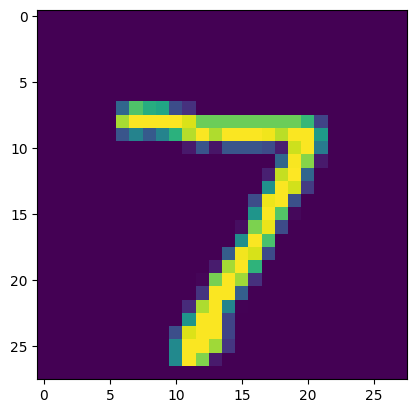

In [4]:
plt.imshow(np.array(data[0][0]))

In [5]:
sys.path.append('../')
from datasets import seq_mnist as sm

In [6]:
testdat = sm.SequentialMNIST(root='../../data/MNIST')

Files already downloaded


In [7]:
torch.max(testdat[0][0])

tensor(0.9874)

In [8]:
import math 
from skimage.transform import resize
import cv2


In [9]:
idx = 0
image = np.array(testdat.data[idx][0], np.float32).reshape(28, 28)
image = resize(image, [24, 24])
image = cv2.copyMakeBorder(
    image, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=(0, 0, 0))
angles_0 = testdat.rng.uniform(0, 2 * math.pi, size=1)
color_0 = testdat.rng.uniform(0, 1, size=1)
pos0 = testdat.rng.uniform(testdat.max_pos[0], testdat.max_pos[1], size=[2])
pos1 = testdat.rng.uniform(testdat.max_pos[0], testdat.max_pos[1], size=[2])


In [10]:
angles_v = testdat.rng.uniform(math.pi * testdat.angle_velocity_range[0],
                            math.pi * testdat.angle_velocity_range[1], size=1)
angles_a = testdat.rng.uniform(math.pi * testdat.angle_accl_range[0],
                            math.pi * testdat.angle_accl_range[1], size=1)
color_v = 0.5 * testdat.rng.uniform(testdat.color_velocity_range[0],
                                 testdat.color_velocity_range[1], size=1)
color_a = 0.5 * \
    testdat.rng.uniform(
        testdat.color_accl_range[0], testdat.color_accl_range[1], size=1)
pos_v = (pos1-pos0)/(testdat.max_T - 1)
pos_a = testdat.rng.uniform(
    testdat.max_trans_accl[0], testdat.max_trans_accl[1], size=[2])

In [11]:
angles_v, angles_a,  color_v,  color_a, pos_v, pos_a 

(array([0.28272507]),
 array([0.]),
 array([-0.03197562]),
 array([0.]),
 array([ 0.97015976, -2.07332784]),
 array([0., 0.]))

In [12]:
t = 1
angles_t = 0.5 * angles_a * t**2 + angles_v * t + angles_0
pos_t = 0.5 * pos_a * t**2 + pos_v * t + pos0
color_t = (0.5 * color_a * t**2 + t * color_v + color_0) % 1
mat = get_RTmat(0, 0, float(angles_t), 32, 32, pos_t[0], pos_t[1])
_image = cv2.warpPerspective(image.copy(), mat, (32, 32))


rgb = np.asarray(colorsys.hsv_to_rgb(color_t[0], 1, 1), dtype=np.float32)
_image = np.concatenate(
    [_image[:, :, None]] * 3, axis=-1) * rgb[None, None]
_image = _image / 255.

if hasattr(testdat, 'backgrnd_data'):
    _imagemask = (np.sum(_image, axis=2, keepdims=True) < 3e-1)
    _image = torch.tensor(
        _image) + self.backgrnd_data[i].permute([1, 2, 0]) * (_imagemask)
    _image = np.array(torch.clip(_image, max=1.))
    


<class 'numpy.ndarray'> float32 (32, 32)
0.98794425 0.0038742912001907825


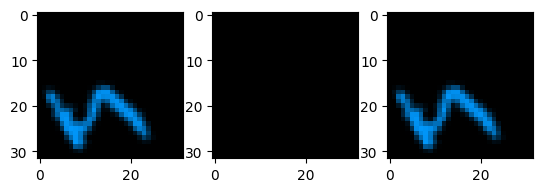

In [13]:
plt.figure()
plt.subplot(1,3,1) 
plt.imshow(_image)
plt.subplot(1,3,2) 
print(type(_image), _image.dtype,  image.shape)
unkoimage = torchvision.transforms.ToTensor()(_image)
plt.imshow(unkoimage)

chinkoimage = torch.tensor(_image)

plt.subplot(1,3,3) 
plt.imshow(chinkoimage)


print(np.max(_image), torch.max(unkoimage).item())

In [14]:
import torchvision
print(torch.__version__)
#print(torchvision.__version__)


1.13.1+cu117


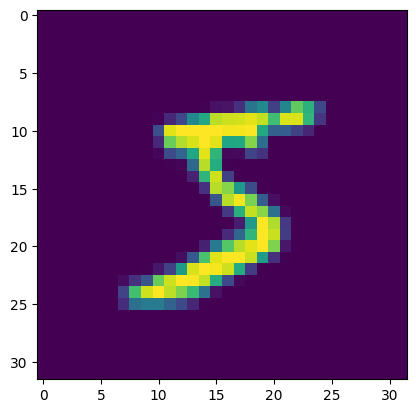

In [15]:
image = np.array(testdat.data[idx][0], np.float32).reshape(28, 28)
image = resize(image, [24, 24])
image = cv2.copyMakeBorder(
    image, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=(0, 0, 0))


plt.imshow(image)

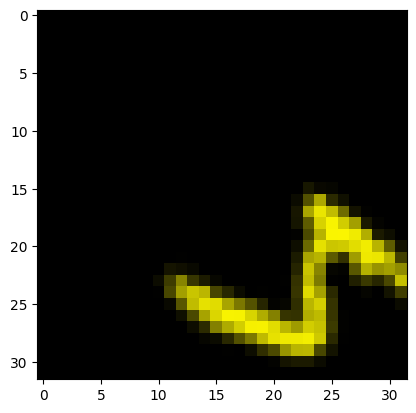

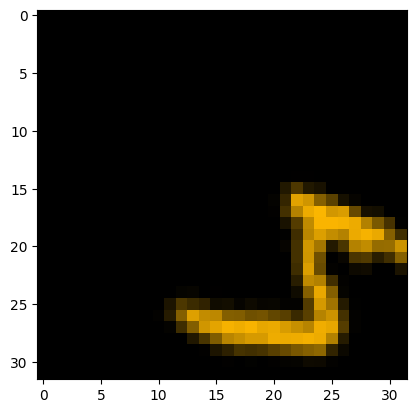

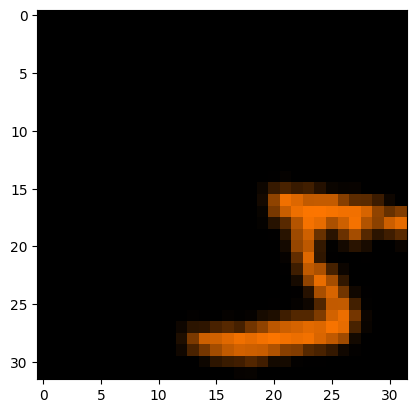

In [16]:

angles_0 = testdat.rng.uniform(0, 2 * math.pi, size=1)
color_0 = testdat.rng.uniform(0, 1, size=1)
pos0 = testdat.rng.uniform(testdat.max_pos[0], testdat.max_pos[1], size=[2])
pos1 = testdat.rng.uniform(testdat.max_pos[0], testdat.max_pos[1], size=[2])
if testdat.shared_transition:
    (angles_v, angles_a) = (testdat.angles_v, testdat.angles_a)
    (color_v, color_a) = (testdat.color_v, testdat.color_a)
    (pos_v, pos_a) = (testdat.pos_v, testdat.pos_a)
else:
    angles_v = testdat.rng.uniform(math.pi * testdat.angle_velocity_range[0],
                                math.pi * testdat.angle_velocity_range[1], size=1)
    angles_a = testdat.rng.uniform(math.pi * testdat.angle_accl_range[0],
                                math.pi * testdat.angle_accl_range[1], size=1)
    color_v = 0.5 * testdat.rng.uniform(testdat.color_velocity_range[0],
                                     testdat.color_velocity_range[1], size=1)
    color_a = 0.5 * \
        testdat.rng.uniform(
            testdat.color_accl_range[0], testdat.color_accl_range[1], size=1)
    pos_v = (pos1-pos0)/(testdat.max_T - 1)
    pos_a = testdat.rng.uniform(
        testdat.max_trans_accl[0], testdat.max_trans_accl[1], size=[2])
images = []
for t in range(testdat.T):
    angles_t = 0.5 * angles_a * t**2 + angles_v * t + angles_0
    pos_t = 0.5 * pos_a * t**2 + pos_v * t + pos0
    color_t = (0.5 * color_a * t**2 + t * color_v + color_0) % 1
    mat = get_RTmat(0, 0, float(angles_t), 32, 32, pos_t[0], pos_t[1])
    _image = cv2.warpPerspective(image.copy(), mat, (32, 32))

    rgb = np.asarray(colorsys.hsv_to_rgb(color_t[0], 1, 1), dtype=np.float32)
    _image = np.concatenate(
        [_image[:, :, None]] * 3, axis=-1) * rgb[None, None]
    _image = _image / 255.



    if hasattr(testdat, 'backgrnd_data'):
        _imagemask = (np.sum(_image, axis=2, keepdims=True) < 3e-1)
        _image = torch.tensor(
            _image) + testdat.backgrnd_data[i].permute([1, 2, 0]) * (_imagemask)
        _image = np.array(torch.clip(_image, max=1.))
    plt.figure()
    plt.imshow(_image.astype(np.float32)) 
    #plt.imshow(testdat.transforms(_image.astype(np.float32)) )
        
    images.append(testdat.transforms(_image.astype(np.float32)))

if testdat.label or testdat.label_velo:
    ret = [images]
    if testdat.label:
        ret += [testdat.data[i][1]]
    if testdat.label_velo:
        ret += [
            freq_to_wave(angles_v.astype(np.float32)),
            freq_to_wave((2 * math.pi * color_v).astype(np.float32)),
            pos_v.astype(np.float32)
        ]
    if testdat.label_accl:
        ret += [
            freq_to_wave(angles_a.astype(np.float32)),
            freq_to_wave((2 * math.pi * color_a).astype(np.float32)),
            pos_a.astype(np.float32)
        ]